In [ ]:
!pip install --upgrade --quiet  langchain langchain-community langchain-openai langchain-experimental langchain-neo4j neo4j wikipedia tiktoken yfiles_jupyter_graphs


[link to neo4j db](https://console.neo4j.io/)

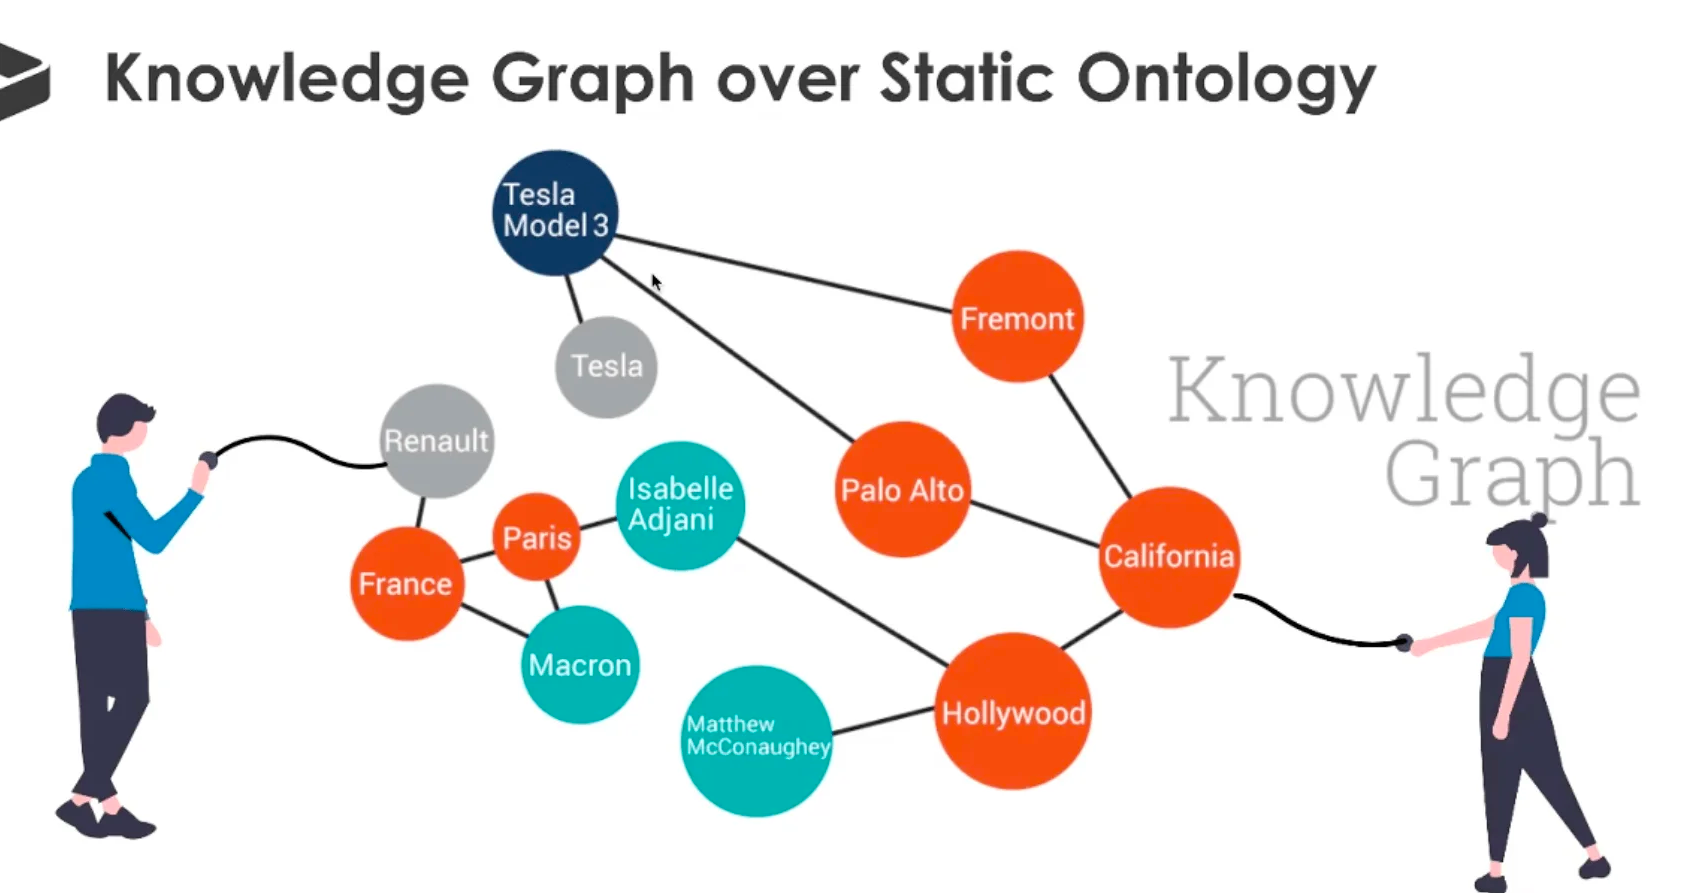

In [ ]:

from langchain_core.runnables import (
    RunnableBranch,
    RunnableLambda,
    RunnableParallel,
    RunnablePassthrough,
)

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts.prompt import PromptTemplate


In [ ]:
from google.colab import userdata
OPENAI_API_KEY=userdata.get('openai_api_key')
from typing import Tuple, List, Optional
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser


In [ ]:
from langchain_core.runnables import ConfigurableField


In [ ]:
from yfiles_jupyter_graphs import GraphWidget
from neo4j import GraphDatabase

In [ ]:
import os
try:
  import google.colab
  from google.colab import output
  output.enable_custom_widget_manager()
except:
  pass


In [ ]:
db_id = "2111957b"
NEO4J_URI=f"neo4j+s://{db_id}.databases.neo4j.io"
NEO4J_USERNAME="neo4j"


In [ ]:
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ["NEO4J_URI"] = NEO4J_URI
os.environ["NEO4J_USERNAME"] = NEO4J_USERNAME
os.environ["NEO4J_PASSWORD"] = userdata.get('NEO4J_PASSWORD')

In [ ]:
from langchain_neo4j import Neo4jGraph

In [ ]:
graph = Neo4jGraph()

In [ ]:

from langchain.document_loaders import WikipediaLoader
raw_documents = WikipediaLoader(query="Elizabeth I").load()

/usr/local/lib/python3.11/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.11/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [ ]:
len(raw_documents)


24

In [ ]:
raw_documents[0].page_content

'Elizabeth I (7 September 1533 – 24 March 1603) was Queen of England and Ireland from 17 November 1558 until her death in 1603. She was the last and longest reigning monarch of the House of Tudor. Her eventful reign, and its effect on history and culture, gave name to the Elizabethan era.\nElizabeth was the only surviving child of Henry VIII and his second wife, Anne Boleyn. When Elizabeth was two years old, her parents\' marriage was annulled, her mother was executed, and Elizabeth was declared illegitimate. Henry restored her to the line of succession when she was 10, via the Third Succession Act 1543. After Henry\'s death in 1547, Elizabeth\'s younger half-brother Edward VI ruled until his own death in 1553, bequeathing the crown to a Protestant cousin, Lady Jane Grey, and ignoring the claims of his two half-sisters, the Catholic Mary and the younger Elizabeth, in spite of statutes to the contrary. Edward\'s will was set aside within weeks of his death and Mary became queen, deposin

In [ ]:
from langchain.text_splitter import TokenTextSplitter
text_splitter = TokenTextSplitter(chunk_size=1024, chunk_overlap=100)
documents = text_splitter.split_documents(raw_documents[:3])


In [ ]:
from langchain_openai import ChatOpenAI
import os
import getpass
# os.environ["OPENAI_API_KEY"] =  getpass.getpass('your openai key')
llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")


In [ ]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
llm_transformer = LLMGraphTransformer(llm=llm)

In [ ]:
graph_documents = llm_transformer.convert_to_graph_documents(documents)




In [ ]:
graph_documents[0]

GraphDocument(nodes=[Node(id='Elizabeth I', type='Person', properties={}), Node(id='Henry Viii', type='Person', properties={}), Node(id='Anne Boleyn', type='Person', properties={}), Node(id='Edward Vi', type='Person', properties={}), Node(id='Mary', type='Person', properties={}), Node(id='Lady Jane Grey', type='Person', properties={}), Node(id='William Cecil', type='Person', properties={}), Node(id='James Vi Of Scotland', type='Person', properties={}), Node(id='Francis Drake', type='Person', properties={}), Node(id='Walter Raleigh', type='Person', properties={}), Node(id='Sir Francis Walsingham', type='Person', properties={}), Node(id='Elizabethan Era', type='Event', properties={}), Node(id='Church Of England', type='Organization', properties={}), Node(id='Greenwich Palace', type='Place', properties={})], relationships=[Relationship(source=Node(id='Elizabeth I', type='Person', properties={}), target=Node(id='Henry Viii', type='Person', properties={}), type='CHILD_OF', properties={}), R

In [ ]:
graph.add_graph_documents(
    graph_documents,
    baseEntityLabel=True,
    include_source=True
)

In [ ]:
default_cypher = "MATCH (s)-[r:!MENTIONS]->(t) RETURN s,r,t LIMIT 50"


In [ ]:
def showGraph(cypher: str = default_cypher):
    # create a neo4j session to run queries
    driver = GraphDatabase.driver(
        uri = os.environ["NEO4J_URI"],
        auth = (os.environ["NEO4J_USERNAME"],
                os.environ["NEO4J_PASSWORD"]))
    session = driver.session()
    widget = GraphWidget(graph = session.run(cypher).graph())
    widget.node_label_mapping = 'id'
    display(widget)
    return widget

In [ ]:
showGraph()

GraphWidget(layout=Layout(height='800px', width='100%'))

GraphWidget(layout=Layout(height='800px', width='100%'))